In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Time to pre-process13.53125
[[ 0.86856754 -0.40877983 -0.28015974]
 [ 0.77129423  0.63565377  0.03239586]
 [ 0.9559678  -0.20735714 -0.20767423]
 ...
 [ 0.92568209  0.37130499 -0.07242432]
 [ 0.9953889   0.01825373 -0.09416865]
 [ 0.99424104  0.09133446 -0.0560604 ]]


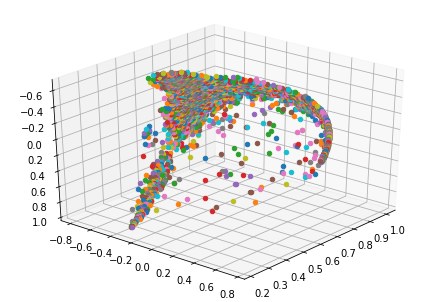

In [2]:
all_texts=[]
Y = []
start = time.process_time()
os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//Reviews")
# os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbc")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
os.chdir('..')
path = os.path.join(os.getcwd(),"GWO")
os.chdir(path)
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
end = time.process_time()
print("Time to pre-process"+str(end-start))
fig=plt.figure()
X = vectors_dense_svd
ax = Axes3D(fig)
print(X)
for j in range(len(X)):
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 140)

In [3]:
max_iter = 100 #Maximum number of iterations
N = 12         #Population size (In the range 5 to 12)
K = 5         #Number of clusters

In [4]:
def population_initialization():
    '''
    Parameters:
    Output:
        N wolves of length K*D where D is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated N times
    '''
    wolves_pack=[]
    for i in range(N):
        wolf=[]
        for j in range(K):
            wolf.append(X[random.randint(0,len(X)-1)])
        wolf=list(itertools.chain(*wolf))
        wolves_pack.append(wolf)
    return wolves_pack

In [5]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [6]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [7]:
def fitness_function(wolf):
    '''
    Input : wolf -> A 1 x d(number of documents) vector containing the initial population
    Output: theta -> Fitness value of each wolf
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
#         clusters[cosine_similarity(centers,X[i])].append(X[i])
        
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][i]
                    t2 = U[k][i]
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
    
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    wolf =[]
    for i in range(len(centers)):
        wolf.extend(centers[i])
    fitness_score = theta
    return fitness_score,wolf

In [8]:
def fitness_evaluation(wolves):
    '''
    Input: wolves -> A N x d dimension matrix containing wolves
    Output:fitness-> A N x 1 dimension vector containing fitness values of all wolves
    '''
    fitness = []
    new_wolves=[]
    for i in range(len(wolves)):
        fit,wolf = fitness_function(wolves[i])
        fitness.append(fit)
        new_wolves.append(wolf)
    return fitness,new_wolves

In [9]:
def find_beta(wolves, fitness):
    alpha = max(fitness)
    beta  = -1000
    for i in fitness:
        if beta<i and i!=alpha:
            beta = i
    return wolves[fitness.index(beta)]

In [10]:
def find_gamma(wolves,fitness, beta):
    alpha = max(fitness)
    gamma = -10000
    for i in fitness:
        if gamma<i and i!=alpha and i!=beta:
            gamma = i
    return wolves[fitness.index(gamma)]

In [11]:
def grey_wolf_optimization():
    gen_fitness = []
    start = time.process_time()
    wolves = population_initialization()
    fitness,wolves= fitness_evaluation(wolves)
    alpha  = wolves[fitness.index(max(fitness))] 
    beta   = find_beta(wolves, fitness)
    gamma  = find_gamma(wolves, fitness, fitness[wolves.index(beta)])
    
    a = 2
    
    C1 = 2*np.random.random(size = len(alpha))
    C2 = 2*np.random.random(size = len(beta))
    C3 = 2*np.random.random(size = len(gamma))
    
    A1 = 2*a*np.random.random(size = len(alpha)) - a 
    A2 = 2*a*np.random.random(size = len(beta)) - a
    A3 = 2*a*np.random.random(size = len(gamma)) - a
    
    t = 0
    while t<max_iter:
        for i in wolves:
            if i!=alpha and i!=beta and i!=gamma:
                D_alpha = np.linalg.norm(np.dot(C1,alpha)-i)
                D_beta  = np.linalg.norm(np.dot(C2,beta)-i)
                D_gamma = np.linalg.norm(np.dot(C3,gamma)-i)

                X1 = alpha - A1*D_alpha
                X2 = beta - A2*D_beta
                X3 = gamma - A3*D_gamma

                i = (X1+X2+X3)/3
        #-----------------------------------------------------
        a = 2 - t*(2/max_iter)
        
        C1 = 2*np.random.random(size = len(alpha))
        C2 = 2*np.random.random(size = len(beta))
        C3 = 2*np.random.random(size = len(gamma))

        A1 = 2*a*np.random.random(size = len(alpha)) - a 
        A2 = 2*a*np.random.random(size = len(beta)) - a
        A3 = 2*a*np.random.random(size = len(gamma)) - a
        
        t = t + 1
        
        fitnes, wolves = fitness_evaluation(wolves)
        temp = []
        temp.append(str(t))
        temp.append(str(max(fitnes)))
        gen_fitness.append(temp)
        print("Generation "+ str(t) + ": "+str(max(fitnes)))
        alpha  = wolves[fitnes.index(max(fitnes))] 
        beta   = find_beta(wolves, fitnes)
        gamma  = find_gamma(wolves, fitnes, fitnes[wolves.index(beta)])
    
    end = time.process_time()
    print("Time taken: " + str(end-start))
    with open('GWO with K='+str(K)+'.csv','w+') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(gen_fitness)
    csvFile.close()
    return alpha

In [12]:
def intracluster_distances(wolf):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [13]:
def davies_bouldin_index(wolf):
    intra_distance = intracluster_distances(wolf)
    
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [14]:
def silhoutette_index(wolf):
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = abs(a-b)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [15]:
def calinski_harabasz(wolf):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    #1. Calculating SSb:
    SSb = 0
    m = np.mean(X)
    for i in range(K):
        SSb += len(clusters[i])*np.square(np.linalg.norm(centers[i]-m))
    
    #2. Calculating SSw:
    SSw = 0
    for i in range(K):
        for j in clusters[i]:
            SSw += np.square(np.linalg.norm(j-centers[i]))
    
    ch_index = (SSb/SSw)*((len(X)-K)/(K-1))
    return ch_index

In [16]:
def dunn_index(wolf):
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(wolf))
    return numerator/denominator

In [17]:
def supervised_scores(wolf):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    Y_pred = []
    for i in range(len(X)):
        Y_pred.append(cosine_similarity(centers,X[i]))
#         Y_pred.append(euclidean_dist_based_center_decision(centers,X[i]))
    
    print(Y_pred)
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [18]:
def plot(wolf):
    centers=[]
    
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
   #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[cosine_similarity(centers,X[i])].append(X[i])
        clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#dd6622','#84ff33','#33ffee','#3395ff','#d2a8fc','#abcdef']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 140)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation 1: 4.328500987635844
Generation 2: 3.849373461920484
Generation 3: 4.027939719067517
Generation 4: 3.9653949715659005
Generation 5: 3.5971094000449675
Generation 6: 3.786844316588229
Generation 7: 3.3227113107916644
Generation 8: 3.2613510098080765
Generation 9: 3.2505797449668368
Generation 10: 3.2438602596093196
Generation 11: 3.246537443779393
Generation 12: 3.248387943297984
Generation 13: 3.248387943297975
Generation 14: 3.248387943297979
Generation 15: 3.2483879432979705
Generation 16: 3.2483879432979643
Generation 17: 3.2483879432979594
Generation 18: 3.248387943297978
Generation 19: 3.2483879432979634
Generation 20: 3.2483879432979723
Generation 21: 3.248387943297972
Generation 22: 3.2483879432979896
Generation 23: 3.2483879432980025
Generation 24: 3.248387943297973
Generation 25: 3.2483879432979594
Generation 26: 3.2483879432979736
Generation 27: 3.2483879432979745
Generation 28: 3.248387943297983
Generation 29: 3.2483879432979883
Generation 30: 3.2483879432979688
G

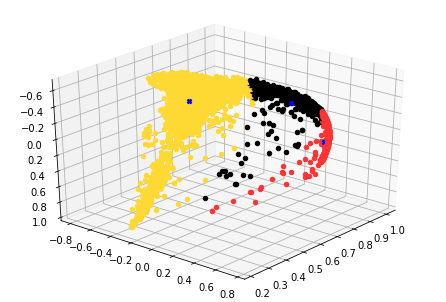

In [23]:
K = 3
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 12.716233098028223
Generation 2: 11.366618511681539
Generation 3: 10.515857145258225
Generation 4: 10.359163966029906
Generation 5: 11.310309285070641
Generation 6: 12.617607491290212
Generation 7: 12.887182363235725
Generation 8: 9.296533976486897
Generation 9: 9.243362287873396
Generation 10: 9.304135726309779
Generation 11: 9.228707009484854
Generation 12: 9.266310467599675
Generation 13: 9.250639967689748
Generation 14: 9.250639967689725
Generation 15: 9.222345416580424
Generation 16: 9.192173041935051
Generation 17: 9.176210079076418
Generation 18: 9.24957804784038
Generation 19: 9.250639967689846
Generation 20: 9.222345416580417
Generation 21: 9.192173041935197
Generation 22: 9.176210079076434
Generation 23: 9.156416436782532
Generation 24: 9.137238212269432
Generation 25: 9.125457086120711
Generation 26: 9.12168418227549
Generation 27: 9.121684182275523
Generation 28: 9.121684182275406
Generation 29: 9.121684182275462
Generation 30: 9.12168418227547
Generation 31: 

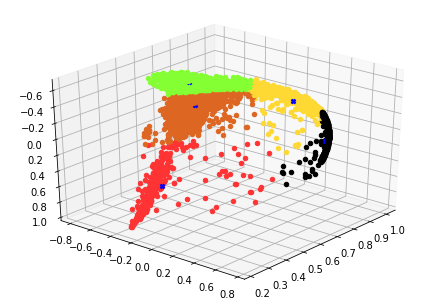

In [24]:
K = 5
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 23.715902958444538
Generation 2: 18.622170198421895
Generation 3: 16.844721733436444
Generation 4: 16.2981854561586
Generation 5: 16.818854045004365
Generation 6: 15.841616572467611
Generation 7: 15.276691552159441
Generation 8: 15.229275322566592
Generation 9: 17.819906952329866
Generation 10: 17.21380415435821
Generation 11: 17.57979415501492
Generation 12: 17.28631530115846
Generation 13: 15.54507503337786
Generation 14: 15.049634914801276
Generation 15: 15.05807508533792
Generation 16: 15.341920317636374
Generation 17: 15.333067360200703
Generation 18: 14.340772427247563
Generation 19: 14.293342159399257
Generation 20: 14.080335224608405
Generation 21: 14.080335224608431
Generation 22: 14.080335224608385
Generation 23: 14.080335224608572
Generation 24: 14.08033522460832
Generation 25: 14.080335224608406
Generation 26: 14.08033522460841
Generation 27: 14.080335224608387
Generation 28: 14.080335224608325
Generation 29: 14.080335224608376
Generation 30: 14.08033522460841

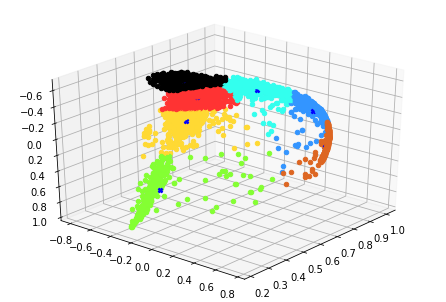

In [25]:
K = 7
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 31.229292078768687
Generation 2: 29.68288613154909
Generation 3: 29.24617321950694
Generation 4: 27.055210169333098
Generation 5: 23.70321502941057
Generation 6: 23.272897054274633
Generation 7: 24.47232870472926
Generation 8: 24.75722649571708
Generation 9: 21.60066538591984
Generation 10: 23.53564573505125
Generation 11: 22.187244760814323
Generation 12: 23.70020034937311
Generation 13: 23.160960826696755
Generation 14: 24.661393880772323
Generation 15: 25.249479401370397
Generation 16: 24.845102848609663
Generation 17: 23.59653913577151
Generation 18: 25.088222890487142
Generation 19: 27.329656911664287
Generation 20: 26.891502031702725
Generation 21: 26.811028272401877
Generation 22: 25.760471452294
Generation 23: 24.54203170034911
Generation 24: 24.629597453388104
Generation 25: 27.537425620491497
Generation 26: 27.39121976121023
Generation 27: 27.45703628716034
Generation 28: 28.71816189113188
Generation 29: 28.689619796169577
Generation 30: 29.878627939780504
Gener

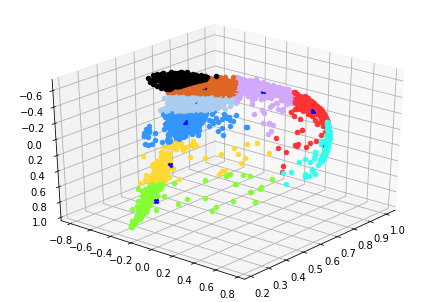

In [26]:
K = 9
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)